# Initialise

In [1]:
# Import

#! /usr/bin/env python

'''
Trains 7D QuaLiKiz-NN with a single output (efiTG)
'''

from __future__ import print_function

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop, adam, Adam
from keras.initializers import TruncatedNormal
from keras import regularizers
from keras import backend as K
import pandas
import numpy
import sys
import os

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from copy import deepcopy
from keras.models import load_model

Using TensorFlow backend.


In [2]:
# Define new Metric: rmse = Root Mean Square Error
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square( y_true-y_pred )))

# Gets the current file name. Useful for procedurally generating output/log files.
file_name =  os.path.basename(sys.argv[0][:-3])

# Define neural network parameters
batch_size = 10
#num_classes = 1
epochs = 100

# Load Data (which is in HDF5 or .h5 format)
store = pandas.HDFStore("../unstable_training_gen2_7D_nions0_flat_filter7.h5")
target_df = store['efeETG_GB'].to_frame()  # This one is relatively easy to train
input_df = store['input']


In [3]:
# Puts inputs and outputs in the same pandas dataframe.
# Also only keeps overlapping entries.
joined_dataFrame = target_df.join(input_df)

# Make a copy of joined_dataFrame for late use
joined_dataFrame_original = deepcopy(joined_dataFrame)

# Normalize data by standard deviation and mean-centering the data
joined_dataFrame['efeETG_GB'] = (joined_dataFrame['efeETG_GB'] - joined_dataFrame['efeETG_GB'].mean()) / joined_dataFrame['efeETG_GB'].std()
joined_dataFrame['Ati'] = (joined_dataFrame['Ati'] - joined_dataFrame['Ati'].mean()) / joined_dataFrame['Ati'].std()
joined_dataFrame['Ate'] = (joined_dataFrame['Ate'] - joined_dataFrame['Ate'].mean()) / joined_dataFrame['Ate'].std()
joined_dataFrame['An'] = (joined_dataFrame['An'] - joined_dataFrame['An'].mean()) / joined_dataFrame['An'].std()
joined_dataFrame['qx'] = (joined_dataFrame['qx'] - joined_dataFrame['qx'].mean()) / joined_dataFrame['qx'].std()
joined_dataFrame['smag'] = (joined_dataFrame['smag'] - joined_dataFrame['smag'].mean()) / joined_dataFrame['smag'].std()
joined_dataFrame['x'] = (joined_dataFrame['x'] - joined_dataFrame['x'].mean()) / joined_dataFrame['x'].std()
joined_dataFrame['Ti_Te'] = (joined_dataFrame['Ti_Te'] - joined_dataFrame['Ti_Te'].mean()) / joined_dataFrame['Ti_Te'].std()

# Shuffles dataset
shuffled_joined_dataFrame = joined_dataFrame.reindex(numpy.random.permutation(
                                                joined_dataFrame.index))

# Creates a pandas dataframe for the outputs
shuffled_clean_output_df = shuffled_joined_dataFrame['efeETG_GB']

# Creates a pandas dataframe for the inputs
shuffled_clean_input_df = shuffled_joined_dataFrame.drop('efeETG_GB', axis=1)

# Creates training dataset (90% of total data) for outputs
y_train = shuffled_clean_output_df.iloc[:int(
    numpy.round(len(shuffled_clean_output_df)*0.9))]

# Creates training dataset (90% of total data) for inputs
x_train = shuffled_clean_input_df.iloc[:int(
    numpy.round(len(shuffled_clean_input_df)*0.9))]

# Creates testing dataset (10% of total data) for outputs
y_test = shuffled_clean_output_df.iloc[int(
    numpy.round(len(shuffled_clean_output_df)*0.9)):]

# Creates testing dataset (10% of total data) for inputs
x_test = shuffled_clean_input_df.iloc[int(
    numpy.round(len(shuffled_clean_input_df)*0.9)):]

# Deletes pandas dataframes that are no longer needed
del target_df, input_df

# Closes the HDFStore. This is good practice.
store.close()

In [4]:
joined_dataFrame.describe(include='all')

,efeETG_GB,Ati,Ate,An,qx,smag,x,Ti_Te
count,638880.000000,6.388800e+05,6.388800e+05,6.388800e+05,6.388800e+05,6.388800e+05,6.388800e+05,6.388800e+05
mean,0.000011,3.921781e-13,-3.483536e-13,5.831676e-14,4.388160e-14,2.038081e-13,-3.500088e-14,1.390060e-13
std,1.000114,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.136391,-1.848058e+00,-2.151526e+00,-4.177720e+00,-8.735150e-01,-1.264894e+00,-1.375825e+00,-1.666559e+00
25%,-0.802423,-6.589535e-01,-6.642361e-01,-6.349019e-01,-6.749461e-01,-3.146967e-01,-9.567490e-01,-9.260135e-01
50%,-0.301873,-1.493374e-01,-1.684729e-01,-4.443218e-02,-4.385544e-01,-5.555202e-02,-1.185980e-01,-6.698017e-02
75%,0.557895,6.150866e-01,4.925446e-01,5.460375e-01,1.524246e-01,4.627374e-01,7.195530e-01,4.217800e-01
max,3.965936,2.908359e+00,1.814580e+00,2.317447e+00,2.516341e+00,3.918000e+00,1.767242e+00,1.665897e+00


In [113]:
joined_dataFrame_original.describe(include='all')

,efeETG_GB,Ati,Ate,An,qx,smag,x,Ti_Te
count,638880.000000,6.388800e+05,638880.000000,638880.000000,638880.000000,638880.000000,638880.000000,638880.000000
mean,26.038572,5.439559e+00,8.509738,2.075249,4.355203,0.464310,0.483960,1.375224
std,22.899494,2.943392e+00,3.025638,1.693567,4.230269,1.157654,0.286345,0.675178
min,0.015788,1.000000e-14,2.000000,-5.000000,0.660000,-1.000000,0.090000,0.250000
25%,7.663502,3.500000e+00,6.500000,1.000000,1.500000,0.100000,0.210000,0.750000
50%,19.125839,5.000000e+00,8.000000,2.000000,2.500000,0.400000,0.450000,1.330000
75%,38.814079,7.250000e+00,10.000000,3.000000,5.000000,1.000000,0.690000,1.660000
max,116.856499,1.400000e+01,14.000000,6.000000,15.000000,5.000000,0.990000,2.500000


### DEBUGGING

In [5]:
joined_dataFrame_original['efeETG_GB'].std()

22.899494171142578

In [6]:
joined_dataFrame_original['Ati'].mean()

5.439558680816429

In [7]:
joined_dataFrame_original.head()

,efeETG_GB,Ati,Ate,An,qx,smag,x,Ti_Te
978721,1.698403,1.000000e-14,2.75,1.0,1.0,0.4,0.84,2.5
981745,0.848584,1.000000e-14,2.75,1.0,1.5,0.1,0.84,2.5
981787,2.298091,1.000000e-14,2.75,1.0,1.5,0.1,0.99,2.5
985063,0.492831,1.000000e-14,2.75,1.0,2.0,0.1,0.69,2.5
985105,2.069086,1.000000e-14,2.75,1.0,2.0,0.1,0.84,2.5


In [8]:
joined_dataFrame.head()

,efeETG_GB,Ati,Ate,An,qx,smag,x,Ti_Te
978721,-1.062913,-1.848058,-1.903644,-0.634902,-0.793142,-0.055552,1.243397,1.665897
981745,-1.100024,-1.848058,-1.903644,-0.634902,-0.674946,-0.314697,1.243397,1.665897
981787,-1.036725,-1.848058,-1.903644,-0.634902,-0.674946,-0.314697,1.767242,1.665897
985063,-1.115559,-1.848058,-1.903644,-0.634902,-0.556750,-0.314697,0.719553,1.665897
985105,-1.046726,-1.848058,-1.903644,-0.634902,-0.556750,-0.314697,1.243397,1.665897


# Load Model

In [9]:
new_model = load_model('../Saved-Networks/2018-07-16_7D_Run0050d.h5', custom_objects={'rmse': rmse})

### DEBUGGING

In [10]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                240       
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_3 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 31        
Total params: 2,131
Trainable params: 2,131
Non-trainable params: 0
_________________________________________________________________


In [11]:
new_model.get_weights()

[array([[-2.87334411e-03,  2.41862200e-02, -4.12066132e-02,
         -1.34515027e-02,  9.28834919e-03,  1.93074974e-03,
         -1.37387365e-02,  4.32844367e-03, -5.89680718e-03,
          2.03450094e-03, -3.67641784e-02, -1.36629390e-02,
          3.24408151e-03, -1.61009077e-02,  1.55328093e-02,
         -5.37062017e-03,  2.79186517e-02,  1.23187387e-02,
          5.63374674e-03,  1.52084474e-02,  5.09614870e-03,
          2.81141233e-02,  8.71234760e-03,  7.75729641e-02,
          2.03094129e-02, -3.85158360e-02,  1.47108687e-02,
         -7.39949122e-02, -5.51870326e-03,  3.68888886e-03],
        [ 1.64472997e-01,  1.06675661e+00,  4.09337372e-01,
          8.65022659e-01,  1.29730806e-01, -7.61756837e-01,
         -9.31763232e-01,  1.19161308e+00,  1.50285649e+00,
         -7.73032486e-01,  6.38422847e-01, -6.03104711e-01,
          6.45129800e-01,  1.58113435e-01, -2.42174134e-01,
         -8.46612215e-01,  3.21146280e-01,  1.58368856e-01,
          1.67071044e-01,  1.47525787e+

In [12]:
new_model.optimizer

# Predictions (Global)

### Predictions - Initialise table to feed predictions

In [13]:
# table (Original values from input file unstable_training_gen2_7D_nions0_flat_filter7.h5)
# Hard-coded variables for the data slice

table = numpy.zeros((200,7))

table[:,0] = 5.75    # Ati
table[:,1] = numpy.linspace(2,14,200)   # Ate
table[:,2] = 3       # An
table[:,3] = 3       # qx
table[:,4] = 0.7     # smag
table[:,5] = 0.45    # x
table[:,6] = 1.33    # Ti_Te

table

array([[ 5.75      ,  2.        ,  3.        , ...,  0.7       ,
         0.45      ,  1.33      ],
       [ 5.75      ,  2.06030151,  3.        , ...,  0.7       ,
         0.45      ,  1.33      ],
       [ 5.75      ,  2.12060302,  3.        , ...,  0.7       ,
         0.45      ,  1.33      ],
       ...,
       [ 5.75      , 13.87939698,  3.        , ...,  0.7       ,
         0.45      ,  1.33      ],
       [ 5.75      , 13.93969849,  3.        , ...,  0.7       ,
         0.45      ,  1.33      ],
       [ 5.75      , 14.        ,  3.        , ...,  0.7       ,
         0.45      ,  1.33      ]])

In [14]:
# table_normalized (Normalised variables used to feed model.predict)

In [15]:
# Data Slice values

DataSlice_Ati = 5.75

In [16]:
'''
# Normalize table
table_normalized = numpy.zeros((200,7))

table_normalized[:,0] = DataSlice_Ati * joined_dataFrame_original['Ati'].std()     # Ati
table_normalized[:,0] = (table_normalized[:,0] * joined_dataFrame_original['Ati'].std()) + joined_dataFrame_original['Ati'].mean()

table_normalized[:,1] = numpy.linspace(2,14,200)   # Ate
table_normalized[:,1] = table_normalized[:,1] * joined_dataFrame_original['Ate'].std()
table_normalized[:,1] = (table_normalized[:,1] * joined_dataFrame_original['Ate'].std()) + joined_dataFrame_original['Ate'].mean()

table_normalized[:,2] = 3 * joined_dataFrame_original['An'].std()      # An
table_normalized[:,2] = (table_normalized[:,2] * joined_dataFrame_original['An'].std()) + joined_dataFrame_original['An'].mean()

table_normalized[:,3] = 3 * joined_dataFrame_original['qx'].std()       # qx
table_normalized[:,3] = (table_normalized[:,3] * joined_dataFrame_original['qx'].std()) + joined_dataFrame_original['qx'].mean()

table_normalized[:,4] = 0.7 * joined_dataFrame_original['smag'].std()     # smag
table_normalized[:,4] = (table_normalized[:,4] * joined_dataFrame_original['smag'].std()) + joined_dataFrame_original['smag'].mean()

table_normalized[:,5] = 0.45 * joined_dataFrame_original['x'].std()    # x
table_normalized[:,5] = (table_normalized[:,5] * joined_dataFrame_original['x'].std()) + joined_dataFrame_original['x'].mean()

table_normalized[:,6] = 1.33 * joined_dataFrame_original['Ti_Te'].std()    # Ti_Te
table_normalized[:,6] = (table_normalized[:,6] * joined_dataFrame_original['Ti_Te'].std()) + joined_dataFrame_original['Ti_Te'].mean()
'''

"\n# Normalize table\ntable_normalized = numpy.zeros((200,7))\n\ntable_normalized[:,0] = DataSlice_Ati * joined_dataFrame_original['Ati'].std()     # Ati\ntable_normalized[:,0] = (table_normalized[:,0] * joined_dataFrame_original['Ati'].std()) + joined_dataFrame_original['Ati'].mean()\n\ntable_normalized[:,1] = numpy.linspace(2,14,200)   # Ate\ntable_normalized[:,1] = table_normalized[:,1] * joined_dataFrame_original['Ate'].std()\ntable_normalized[:,1] = (table_normalized[:,1] * joined_dataFrame_original['Ate'].std()) + joined_dataFrame_original['Ate'].mean()\n\ntable_normalized[:,2] = 3 * joined_dataFrame_original['An'].std()      # An\ntable_normalized[:,2] = (table_normalized[:,2] * joined_dataFrame_original['An'].std()) + joined_dataFrame_original['An'].mean()\n\ntable_normalized[:,3] = 3 * joined_dataFrame_original['qx'].std()       # qx\ntable_normalized[:,3] = (table_normalized[:,3] * joined_dataFrame_original['qx'].std()) + joined_dataFrame_original['qx'].mean()\n\ntable_normal

In [17]:
# Normalized table (inputs for model.predict())
table_normalized_Mk2 = numpy.zeros((200,7))

DataSlice_Ati = 5.75
DataSlice_Ate = numpy.linspace(2,14,200)
DataSlice_An = 3
DataSlice_qx = 3
DataSlice_smag = 0.7
DataSlice_x = 0.45
DataSlice_Ti_Te = 1.33

# Normalize data by standard deviation and mean-centering the data
table_normalized_Mk2[:,0] = (DataSlice_Ati - joined_dataFrame_original['Ati'].mean()) / joined_dataFrame_original['Ati'].std()
table_normalized_Mk2[:,1] = (DataSlice_Ate - joined_dataFrame_original['Ate'].mean()) / joined_dataFrame_original['Ate'].std()
table_normalized_Mk2[:,2] = (DataSlice_An - joined_dataFrame_original['An'].mean()) / joined_dataFrame_original['An'].std()
table_normalized_Mk2[:,3] = (DataSlice_qx - joined_dataFrame_original['qx'].mean()) / joined_dataFrame_original['qx'].std()
table_normalized_Mk2[:,4] = (DataSlice_smag - joined_dataFrame_original['smag'].mean()) / joined_dataFrame_original['smag'].std()
table_normalized_Mk2[:,5] = (DataSlice_x - joined_dataFrame_original['x'].mean()) / joined_dataFrame_original['x'].std()
table_normalized_Mk2[:,6] = (DataSlice_Ti_Te - joined_dataFrame_original['Ti_Te'].mean()) / joined_dataFrame_original['Ti_Te'].std()

In [18]:
# joined_dataFrame.to_csv('./out_joined_dataFrame.csv', encoding='utf-8')

In [19]:
'''
# Alternative inputs for model.predict()

# Creates a pandas dataframe for the inputs
shuffled_clean_input_df_normalized = joined_dataFrame.drop('efeETG_GB', axis=1)
shuffled_clean_input_df = shuffled_joined_dataFrame.drop('efeETG_GB', axis=1)

# Creates training dataset (90% of total data) for inputs
x_train_normalized = shuffled_clean_input_df_normalized.iloc[:int(
    numpy.round(len(shuffled_clean_input_df_normalized)*0.9))]
x_train = shuffled_clean_input_df.iloc[:int(
    numpy.round(len(shuffled_clean_input_df)*0.9))]
'''

"\n# Alternative inputs for model.predict()\n\n# Creates a pandas dataframe for the inputs\nshuffled_clean_input_df_normalized = joined_dataFrame.drop('efeETG_GB', axis=1)\nshuffled_clean_input_df = shuffled_joined_dataFrame.drop('efeETG_GB', axis=1)\n\n# Creates training dataset (90% of total data) for inputs\nx_train_normalized = shuffled_clean_input_df_normalized.iloc[:int(\n    numpy.round(len(shuffled_clean_input_df_normalized)*0.9))]\nx_train = shuffled_clean_input_df.iloc[:int(\n    numpy.round(len(shuffled_clean_input_df)*0.9))]\n"

In [20]:
# Alternative inputs for model.predict()

table_Hard_Coded = numpy.zeros((200,7))

table_Hard_Coded[:,0] = 0.105470582045568          # Ati (5.75)
table_Hard_Coded[:,1] = numpy.linspace(-2.15152556643333,1.81457971458693,200)   # Ate (numpy.linspace(2,14,200))
table_Hard_Coded[:,2] = 0.54603754363089           # An (3)
table_Hard_Coded[:,3] = -0.438554449031191         # qx (3)
table_Hard_Coded[:,4] = 0.203592672793338          # smag (0.7)
table_Hard_Coded[:,5] = -0.118598044880004         # x (0.45)
table_Hard_Coded[:,6] = -0.0669801660705659        # Ti_Te (1.33)

table_Hard_Coded

array([[ 0.10547058, -2.15152557,  0.54603754, ...,  0.20359267,
        -0.11859804, -0.06698017],
       [ 0.10547058, -2.13159539,  0.54603754, ...,  0.20359267,
        -0.11859804, -0.06698017],
       [ 0.10547058, -2.11166521,  0.54603754, ...,  0.20359267,
        -0.11859804, -0.06698017],
       ...,
       [ 0.10547058,  1.77471936,  0.54603754, ...,  0.20359267,
        -0.11859804, -0.06698017],
       [ 0.10547058,  1.79464954,  0.54603754, ...,  0.20359267,
        -0.11859804, -0.06698017],
       [ 0.10547058,  1.81457971,  0.54603754, ...,  0.20359267,
        -0.11859804, -0.06698017]])

In [21]:
y_test_np_array = y_test.values
print(y_test_np_array)

[ 0.8727488  -1.09049082 -1.12176487 ... -0.78085492 -0.52065092
 -0.89247151]


In [22]:
x_test_np_array = x_test.values
print(x_test_np_array)

[[ 0.61508661 -0.41635451 -0.93013677 ... -0.05555202  0.30047748
  -0.9260135 ]
 [-0.40414545 -1.15999925  1.13650727 ... -0.31469673 -1.37582451
   1.66589724]
 [ 0.61508661 -1.65576241  0.25080268 ...  0.20359267  1.76724181
   0.42178003]
 ...
 [-0.65895347  1.81457971 -2.99678081 ... -1.26489399  0.719553
  -1.66655943]
 [-1.1685695  -0.41635451 -0.63490191 ... -0.31469673 -0.11859804
  -0.9260135 ]
 [-0.14933743 -1.15999925 -0.63490191 ... -1.26489399  0.30047748
  -0.06698017]]


In [23]:
predictions_global = new_model.predict(x_test_np_array, batch_size = 10, verbose=0)
print(type(predictions_global))

predictions_global = predictions_global.flatten()
print(predictions_global.shape)
print(type(predictions_global))

<class 'numpy.ndarray'>
(63888,)
<class 'numpy.ndarray'>


In [24]:
predictions = new_model.predict(table_Hard_Coded, batch_size = 10, verbose=0)
print(type(predictions))

predictions = predictions.flatten()
print(predictions.shape)
print(type(predictions))

<class 'numpy.ndarray'>
(200,)
<class 'numpy.ndarray'>


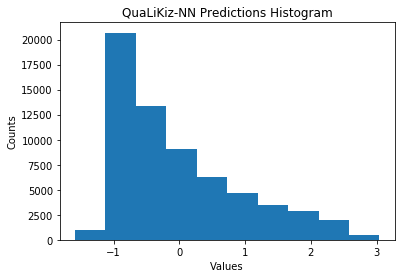

In [25]:
plt.hist(predictions_global)
plt.title('QuaLiKiz-NN Predictions Histogram')
plt.xlabel('Values')
plt.ylabel('Counts')
# plt.savefig('./2018-07-10_Run0050b_DataSlicerPlot/NN_Predictions.png', dpi = 100)
plt.show()

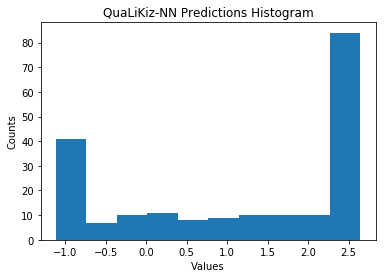

In [26]:
plt.hist(predictions)
plt.title('QuaLiKiz-NN Predictions Histogram')
plt.xlabel('Values')
plt.ylabel('Counts')
# plt.savefig('./2018-07-10_Run0050b_DataSlicerPlot/NN_Predictions.png', dpi = 100)
plt.show()

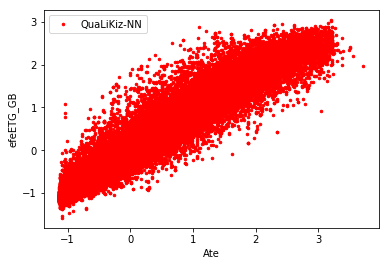

In [27]:
# efeETG_DF = newDF['efeETG_GB']
# Ate_DF = newDF['Ate']
plt.plot(y_test_np_array, predictions_global, 'r.', ms = 5, label = 'QuaLiKiz-NN')
# plt.plot(Ate_DF_np_array, efeETG_DF_np_array, 'b.', ms = 5, label = 'QuaLiKiz')
plt.xlabel('Ate')
plt.ylabel('efeETG_GB')
plt.legend()
plt.show()

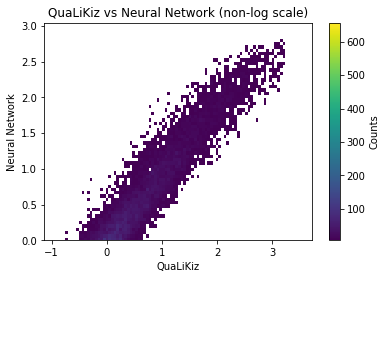

In [28]:
plt.hist2d(y_test_np_array, predictions_global, bins=100, cmin=5)
# plt.plot( [0,1],[0,1] )
plt.title('QuaLiKiz vs Neural Network (non-log scale)')
plt.xlabel('QuaLiKiz')
plt.ylabel('Neural Network')
plt.ylim(0)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')
# plt.savefig('./2018-07-10_Run0050b_DataSlicerPlot/QuaLiKiz-vs-NN_nonLogScale_bins100.png', dpi = 100)
plt.show()

C:\Users\danie\Anaconda3\lib\site-packages\matplotlib\colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


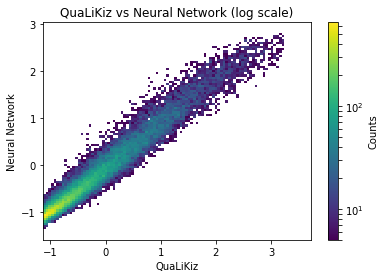

In [29]:
plt.hist2d(y_test_np_array, predictions_global, bins=100, norm=LogNorm(), cmin=5)
# plt.plot( [0,1],[0,1] )
plt.title('QuaLiKiz vs Neural Network (log scale)')
plt.xlabel('QuaLiKiz')
plt.ylabel('Neural Network')
# plt.ylim(0)
# plt.xlim(0)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')
plt.show()

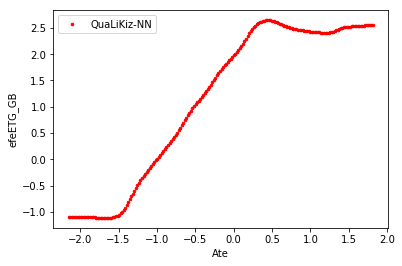

In [30]:
# efeETG_DF = newDF['efeETG_GB']
# Ate_DF = newDF['Ate']
plt.plot(table_Hard_Coded[:,1], predictions, 'r.', ms = 5, label = 'QuaLiKiz-NN')
# plt.plot(Ate_DF_np_array, efeETG_DF_np_array, 'b.', ms = 5, label = 'QuaLiKiz')
plt.xlabel('Ate')
plt.ylabel('efeETG_GB')
plt.legend()
plt.show()

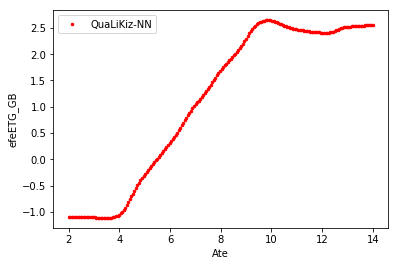

In [31]:
# efeETG_DF = newDF['efeETG_GB']
# Ate_DF = newDF['Ate']
plt.plot(table[:,1], predictions, 'r.', ms = 5, label = 'QuaLiKiz-NN')
# plt.plot(Ate_DF_np_array, efeETG_DF_np_array, 'b.', ms = 5, label = 'QuaLiKiz')
plt.xlabel('Ate')
plt.ylabel('efeETG_GB')
plt.legend()
plt.show()

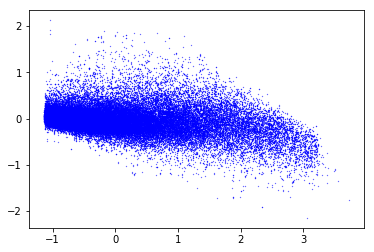

In [32]:
plt.plot(y_test_np_array, predictions_global - y_test_np_array, 'b.', ms = 0.5)

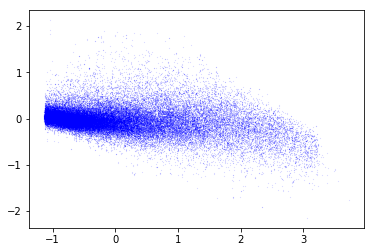

In [33]:
plt.plot(y_test_np_array, predictions_global - y_test_np_array, 'b.', ms = 0.1)

In [34]:
# Normalizes data (no standardization necessary due to dataset design)
table_normalized_MinMax = table/table.max().astype(numpy.float64)
print(table_normalized_MinMax.shape)
print(type(table_normalized_MinMax))

(200, 7)
<class 'numpy.ndarray'>


In [35]:
new_predictions_normalized = new_model.predict(table_normalized_MinMax, batch_size = 10, verbose=0)
new_predictions_normalized.flatten()
# new_predictions_normalized = new_predictions_normalized.flatten()

array([2.458621 , 2.460805 , 2.4629502, 2.4650574, 2.4671278, 2.46916  ,
       2.4711533, 2.4731097, 2.4750285, 2.4769082, 2.4787507, 2.4805555,
       2.4823232, 2.4840522, 2.485743 , 2.4873972, 2.4890127, 2.4905906,
       2.4921303, 2.4936323, 2.4950967, 2.496523 , 2.4979115, 2.4992614,
       2.500574 , 2.5018477, 2.5030837, 2.5042806, 2.5054393, 2.5065598,
       2.5076418, 2.508685 , 2.5096893, 2.5106559, 2.5115824, 2.5124702,
       2.5133195, 2.5141292, 2.5148997, 2.5156317, 2.516324 , 2.5169759,
       2.5175905, 2.5181646, 2.5186996, 2.5191946, 2.51965  , 2.5200667,
       2.5204444, 2.5207815, 2.5210795, 2.5213394, 2.5215588, 2.52174  ,
       2.521882 , 2.521985 , 2.52205  , 2.5220761, 2.5220647, 2.5220146,
       2.5219278, 2.5218024, 2.5216408, 2.5214424, 2.5212073, 2.5209365,
       2.5206304, 2.520288 , 2.5199122, 2.5195022, 2.5190578, 2.518581 ,
       2.5180712, 2.5175295, 2.5169563, 2.5163531, 2.5157194, 2.5150566,
       2.5143647, 2.5136461, 2.5128994, 2.512127 , 

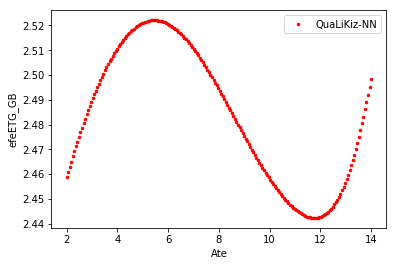

In [36]:
# efeETG_DF = newDF['efeETG_GB']
# Ate_DF = newDF['Ate']
plt.plot(table[:,1], new_predictions_normalized, 'r.', ms = 5, label = 'QuaLiKiz-NN')
# plt.plot(Ate_DF_np_array, efeETG_DF_np_array, 'b.', ms = 5, label = 'QuaLiKiz')
plt.xlabel('Ate')
plt.ylabel('efeETG_GB')
plt.legend()
plt.show()

# Predictions (single Data Slice)

In [38]:
'''
efeETG_DF = newDF['efeETG_GB']
efeETG_DF_np_array = efeETG_DF.values
print(efeETG_DF_np_array)

Ate_DF = newDF['Ate']
Ate_DF_np_array = Ate_DF.values
print(Ate_DF_np_array)
'''

"\nefeETG_DF = newDF['efeETG_GB']\nefeETG_DF_np_array = efeETG_DF.values\nprint(efeETG_DF_np_array)\n\nAte_DF = newDF['Ate']\nAte_DF_np_array = Ate_DF.values\nprint(Ate_DF_np_array)\n"

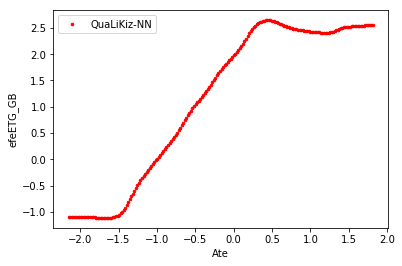

In [39]:
# efeETG_DF = newDF['efeETG_GB']
# Ate_DF = newDF['Ate']
plt.plot(table_Hard_Coded[:,1], predictions, 'r.', ms = 5, label = 'QuaLiKiz-NN')
# plt.plot(Ate_DF_np_array, efeETG_DF_np_array, 'b.', ms = 5, label = 'QuaLiKiz')
plt.xlabel('Ate')
plt.ylabel('efeETG_GB')
plt.legend()
plt.show()

In [40]:
table_normalized_legacy = numpy.loadtxt('table_normalized_legacy.txt')

In [41]:
table_normalized_legacy

array([[0.41, 0.14, 0.21, ..., 0.05, 0.03, 0.1 ],
       [0.41, 0.15, 0.21, ..., 0.05, 0.03, 0.1 ],
       [0.41, 0.15, 0.21, ..., 0.05, 0.03, 0.1 ],
       ...,
       [0.41, 0.99, 0.21, ..., 0.05, 0.03, 0.1 ],
       [0.41, 1.  , 0.21, ..., 0.05, 0.03, 0.1 ],
       [0.41, 1.  , 0.21, ..., 0.05, 0.03, 0.1 ]])

In [42]:
predictions_test = new_model
predictions_test = new_model.predict(table_normalized_legacy, batch_size = 10, verbose=0)
new_predictions_normalized = new_predictions_normalized.flatten()

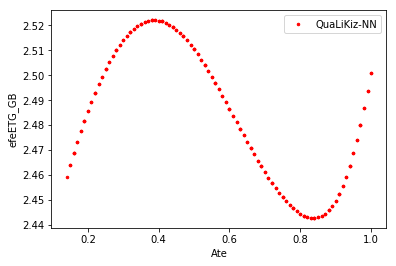

In [43]:
# efeETG_DF = newDF['efeETG_GB']
# Ate_DF = newDF['Ate']
plt.plot(table_normalized_legacy[:,1], predictions_test, 'r.', ms = 5, label = 'QuaLiKiz-NN')
# plt.plot(Ate_DF_np_array, efeETG_DF_np_array, 'b.', ms = 5, label = 'QuaLiKiz')
plt.xlabel('Ate')
plt.ylabel('efeETG_GB')
plt.legend()
plt.show()

In [44]:
# DEBUGGING

In [45]:
predictions_Mk2 = new_model.predict(table_normalized_Mk2, batch_size = 10, verbose=0)
print(type(predictions_Mk2))

predictions_Mk2 = predictions_Mk2.flatten()
print(predictions_Mk2.shape)
print(type(predictions_Mk2))

<class 'numpy.ndarray'>
(200,)
<class 'numpy.ndarray'>


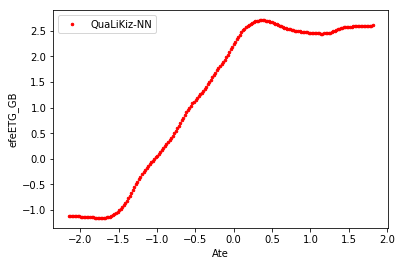

In [46]:
# efeETG_DF = newDF['efeETG_GB']
# Ate_DF = newDF['Ate']
plt.plot(table_normalized_Mk2[:,1], predictions_Mk2, 'r.', ms = 5, label = 'QuaLiKiz-NN')
# plt.plot(Ate_DF_np_array, efeETG_DF_np_array, 'b.', ms = 5, label = 'QuaLiKiz')
plt.xlabel('Ate')
plt.ylabel('efeETG_GB')
plt.legend()
plt.show()

In [47]:
table_normalized_Mk2

array([[ 0.10547058, -2.15152557,  0.54603754, ...,  0.20359268,
        -0.118598  , -0.06698023],
       [ 0.10547058, -2.13159539,  0.54603754, ...,  0.20359268,
        -0.118598  , -0.06698023],
       [ 0.10547058, -2.11166521,  0.54603754, ...,  0.20359268,
        -0.118598  , -0.06698023],
       ...,
       [ 0.10547058,  1.77471936,  0.54603754, ...,  0.20359268,
        -0.118598  , -0.06698023],
       [ 0.10547058,  1.79464954,  0.54603754, ...,  0.20359268,
        -0.118598  , -0.06698023],
       [ 0.10547058,  1.81457971,  0.54603754, ...,  0.20359268,
        -0.118598  , -0.06698023]])

In [48]:
table_normalized_Mk2_DF = pandas.DataFrame(table_normalized_Mk2)

In [49]:
table_normalized_Mk2_DF

,0,1,2,3,4,5,6
0,0.105471,-2.151526,0.546038,-0.320359,0.203593,-0.118598,-0.06698
1,0.105471,-2.131595,0.546038,-0.320359,0.203593,-0.118598,-0.06698
2,0.105471,-2.111665,0.546038,-0.320359,0.203593,-0.118598,-0.06698
3,0.105471,-2.091735,0.546038,-0.320359,0.203593,-0.118598,-0.06698
4,0.105471,-2.071805,0.546038,-0.320359,0.203593,-0.118598,-0.06698
5,0.105471,-2.051875,0.546038,-0.320359,0.203593,-0.118598,-0.06698
6,0.105471,-2.031945,0.546038,-0.320359,0.203593,-0.118598,-0.06698
7,0.105471,-2.012014,0.546038,-0.320359,0.203593,-0.118598,-0.06698
8,0.105471,-1.992084,0.546038,-0.320359,0.203593,-0.118598,-0.06698
9,0.105471,-1.972154,0.546038,-0.320359,0.203593,-0.118598,-0.06698


In [51]:
'''
table_normalized_Mk2_DF.describe('all')
'''

"\ntable_normalized_Mk2_DF.describe('all')\n"

In [52]:
print(type(x_test_np_array))

<class 'numpy.ndarray'>


In [53]:
print(x_test_np_array.shape)

(63888, 7)


In [54]:
print(type(table_normalized_Mk2))

<class 'numpy.ndarray'>


(array([40.,  7., 10., 10.,  8.,  9., 10.,  8.,  8., 90.]),
 array([-1.15361309, -0.76752782, -0.38144255,  0.00464272,  0.390728  ,
         0.77681327,  1.16289854,  1.54898381,  1.93506908,  2.32115436,
         2.70723963]),
 <a list of 10 Patch objects>)

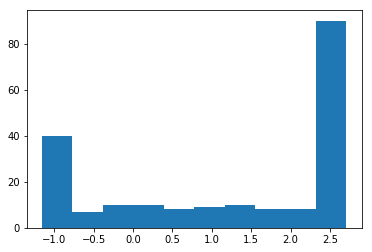

In [55]:
plt.hist(predictions_Mk2)

In [56]:
joined_dataFrame.describe(include='all')

,efeETG_GB,Ati,Ate,An,qx,smag,x,Ti_Te
count,638880.000000,6.388800e+05,6.388800e+05,6.388800e+05,6.388800e+05,6.388800e+05,6.388800e+05,6.388800e+05
mean,0.000011,3.921781e-13,-3.483536e-13,5.831676e-14,4.388160e-14,2.038081e-13,-3.500088e-14,1.390060e-13
std,1.000114,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.136391,-1.848058e+00,-2.151526e+00,-4.177720e+00,-8.735150e-01,-1.264894e+00,-1.375825e+00,-1.666559e+00
25%,-0.802423,-6.589535e-01,-6.642361e-01,-6.349019e-01,-6.749461e-01,-3.146967e-01,-9.567490e-01,-9.260135e-01
50%,-0.301873,-1.493374e-01,-1.684729e-01,-4.443218e-02,-4.385544e-01,-5.555202e-02,-1.185980e-01,-6.698017e-02
75%,0.557895,6.150866e-01,4.925446e-01,5.460375e-01,1.524246e-01,4.627374e-01,7.195530e-01,4.217800e-01
max,3.965936,2.908359e+00,1.814580e+00,2.317447e+00,2.516341e+00,3.918000e+00,1.767242e+00,1.665897e+00


In [57]:
joined_dataFrame_original.describe(include='all')

,efeETG_GB,Ati,Ate,An,qx,smag,x,Ti_Te
count,638880.000000,6.388800e+05,638880.000000,638880.000000,638880.000000,638880.000000,638880.000000,638880.000000
mean,26.038572,5.439559e+00,8.509738,2.075249,4.355203,0.464310,0.483960,1.375224
std,22.899494,2.943392e+00,3.025638,1.693567,4.230269,1.157654,0.286345,0.675178
min,0.015788,1.000000e-14,2.000000,-5.000000,0.660000,-1.000000,0.090000,0.250000
25%,7.663502,3.500000e+00,6.500000,1.000000,1.500000,0.100000,0.210000,0.750000
50%,19.125839,5.000000e+00,8.000000,2.000000,2.500000,0.400000,0.450000,1.330000
75%,38.814079,7.250000e+00,10.000000,3.000000,5.000000,1.000000,0.690000,1.660000
max,116.856499,1.400000e+01,14.000000,6.000000,15.000000,5.000000,0.990000,2.500000


# Masks

#### Ate

In [58]:
Ate_mask1 = joined_dataFrame_original.Ate == 2
Ate_mask2 = joined_dataFrame_original.Ate == 2.75
Ate_mask3 = joined_dataFrame_original.Ate == 3.5
Ate_mask4 = joined_dataFrame_original.Ate == 4.25
Ate_mask5 = joined_dataFrame_original.Ate == 5
Ate_mask6 = joined_dataFrame_original.Ate == 5.75
Ate_mask7 = joined_dataFrame_original.Ate == 6.5
Ate_mask8 = joined_dataFrame_original.Ate == 7.25
Ate_mask9 = joined_dataFrame_original.Ate == 8
Ate_mask10 = joined_dataFrame_original.Ate == 10
Ate_mask11 = joined_dataFrame_original.Ate == 14

Ate_anti_mask1 = joined_dataFrame_original.Ate != 2
Ate_anti_mask2 = joined_dataFrame_original.Ate != 2.75
Ate_anti_mask3 = joined_dataFrame_original.Ate != 3.5
Ate_anti_mask4 = joined_dataFrame_original.Ate != 4.25
Ate_anti_mask5 = joined_dataFrame_original.Ate != 5
Ate_anti_mask6 = joined_dataFrame_original.Ate != 5.75
Ate_anti_mask7 = joined_dataFrame_original.Ate != 6.5
Ate_anti_mask8 = joined_dataFrame_original.Ate != 7.25
Ate_anti_mask9 = joined_dataFrame_original.Ate != 8
Ate_anti_mask10 = joined_dataFrame_original.Ate != 10
Ate_anti_mask11 = joined_dataFrame_original.Ate != 14

#### An

In [59]:
An_mask1 = joined_dataFrame_original.An == -5
An_mask2 = joined_dataFrame_original.An == -3
An_mask3 = joined_dataFrame_original.An == -1
An_mask4 = numpy.array(joined_dataFrame_original.An <= 1.1e-14) * numpy.array(joined_dataFrame_original.An >= 9E-15)
An_mask5 = joined_dataFrame_original.An == 0.5
An_mask6 = joined_dataFrame_original.An == 1.0
An_mask7 = joined_dataFrame_original.An == 1.5
An_mask8 = joined_dataFrame_original.An == 2.0
An_mask9 = joined_dataFrame_original.An == 2.5
An_mask10 = joined_dataFrame_original.An == 3.0
An_mask11 = joined_dataFrame_original.An == 4.0
An_mask12 = joined_dataFrame_original.An == 6.0

An_anti_mask1 = joined_dataFrame_original.An != -5
An_anti_mask2 = joined_dataFrame_original.An != -3
An_anti_mask3 = joined_dataFrame_original.An != -1
An_anti_mask4 = numpy.array(joined_dataFrame_original.An >= 1.1e-14) * numpy.array(joined_dataFrame_original.An <= 9E-15)
An_anti_mask5 = joined_dataFrame_original.An != 0.5
An_anti_mask6 = joined_dataFrame_original.An != 1.0
An_anti_mask7 = joined_dataFrame_original.An != 1.5
An_anti_mask8 = joined_dataFrame_original.An != 2.0
An_anti_mask9 = joined_dataFrame_original.An != 2.5
An_anti_mask10 = joined_dataFrame_original.An != 3.0
An_anti_mask11 = joined_dataFrame_original.An != 4.0
An_anti_mask12 = joined_dataFrame_original.An != 6.0

#### Ati

In [60]:
Ati_mask1 = numpy.array(joined_dataFrame_original.Ati <= 1.1e-14) * numpy.array(joined_dataFrame_original.Ati >= 9E-15)
Ati_mask2 = joined_dataFrame_original.Ati == 2
Ati_mask3 = joined_dataFrame_original.Ati == 2.75
Ati_mask4 = joined_dataFrame_original.Ati == 3.5
Ati_mask5 = joined_dataFrame_original.Ati == 4.25
Ati_mask6 = joined_dataFrame_original.Ati == 5
Ati_mask7 = joined_dataFrame_original.Ati == 5.75
Ati_mask8 = joined_dataFrame_original.Ati == 6.5
Ati_mask9 = joined_dataFrame_original.Ati == 7.25
Ati_mask10 = joined_dataFrame_original.Ati == 8
Ati_mask11 = joined_dataFrame_original.Ati == 10
Ati_mask12 = joined_dataFrame_original.Ati == 14

#### qx

In [61]:
qx_mask0 = numpy.array(joined_dataFrame_original.qx <= 0.67) * numpy.array(joined_dataFrame_original.qx >= 0.65)  #0.66
qx_mask1 = joined_dataFrame_original.qx == 1.0
qx_mask2 = joined_dataFrame_original.qx == 1.5
qx_mask3 = joined_dataFrame_original.qx == 2.0
qx_mask4 = joined_dataFrame_original.qx == 2.5
qx_mask5 = joined_dataFrame_original.qx == 3.0
qx_mask6 = joined_dataFrame_original.qx == 4.0
qx_mask7 = joined_dataFrame_original.qx == 5.0
qx_mask8 = joined_dataFrame_original.qx == 10.00
qx_mask9 = joined_dataFrame_original.qx == 15.00

qx_anti_mask0 = numpy.array(joined_dataFrame_original.qx >= 0.67) * numpy.array(joined_dataFrame_original.qx <= 0.65)  #0.66
qx_anti_mask1 = joined_dataFrame_original.qx != 1.0
qx_anti_mask2 = joined_dataFrame_original.qx != 1.5
qx_anti_mask3 = joined_dataFrame_original.qx != 2.0
qx_anti_mask4 = joined_dataFrame_original.qx != 2.5
qx_anti_mask5 = joined_dataFrame_original.qx != 3.0
qx_anti_mask6 = joined_dataFrame_original.qx != 4.0
qx_anti_mask7 = joined_dataFrame_original.qx != 5.0
qx_anti_mask8 = joined_dataFrame_original.qx != 10.00
qx_anti_mask9 = joined_dataFrame_original.qx != 15.00

#### smag

In [62]:
smag_mask1 = joined_dataFrame_original.smag == -1.0
smag_mask2 = numpy.array(joined_dataFrame_original.smag <= 0.11) * numpy.array(joined_dataFrame_original.smag >= 0.09)   # 0.1
smag_mask3 = numpy.array(joined_dataFrame_original.smag <= 0.41) * numpy.array(joined_dataFrame_original.smag >= 0.39)   # 0.4
smag_mask4 = numpy.array(joined_dataFrame_original.smag <= 0.71) * numpy.array(joined_dataFrame_original.smag >= 0.68)   # 0.7
smag_mask5 = joined_dataFrame_original.smag == 1
smag_mask6 = joined_dataFrame_original.smag == 1.5
smag_mask7 = joined_dataFrame_original.smag == 2.0
smag_mask8 = joined_dataFrame_original.smag == 2.75
smag_mask9 = joined_dataFrame_original.smag == 3.5
smag_mask10 = joined_dataFrame_original.smag == 5.0

smag_anti_mask1 = joined_dataFrame_original.smag != -1.0
smag_anti_mask2 = numpy.array(joined_dataFrame_original.smag >= 0.11) * numpy.array(joined_dataFrame_original.smag <= 0.09)   # 0.1
smag_anti_mask3 = numpy.array(joined_dataFrame_original.smag >= 0.41) * numpy.array(joined_dataFrame_original.smag <= 0.39)   # 0.4
smag_anti_mask4 = numpy.array(joined_dataFrame_original.smag >= 0.71) * numpy.array(joined_dataFrame_original.smag <= 0.68)   # 0.7
smag_anti_mask5 = joined_dataFrame_original.smag != 1
smag_anti_mask6 = joined_dataFrame_original.smag != 1.5
smag_anti_mask7 = joined_dataFrame_original.smag != 2.0
smag_anti_mask8 = joined_dataFrame_original.smag != 2.75
smag_anti_mask9 = joined_dataFrame_original.smag != 3.5
smag_anti_mask10 = joined_dataFrame_original.smag != 5.0

#### x

In [63]:
x_mask1 = numpy.array(joined_dataFrame_original.x <= 0.10) * numpy.array(joined_dataFrame_original.x >= 0.08)   # 0.09
x_mask2 = numpy.array(joined_dataFrame_original.x <= 0.22) * numpy.array(joined_dataFrame_original.x >= 0.20)   # 0.21
x_mask3 = numpy.array(joined_dataFrame_original.x <= 0.34) * numpy.array(joined_dataFrame_original.x >= 0.32)   # 0.33
x_mask4 = numpy.array(joined_dataFrame_original.x <= 0.46) * numpy.array(joined_dataFrame_original.x >= 0.44)   # 0.45
x_mask5 = numpy.array(joined_dataFrame_original.x <= 0.58) * numpy.array(joined_dataFrame_original.x >= 0.56)   # 0.57
x_mask6 = numpy.array(joined_dataFrame_original.x <= 0.70) * numpy.array(joined_dataFrame_original.x >= 0.68)   # 0.69
x_mask7 = numpy.array(joined_dataFrame_original.x <= 0.85) * numpy.array(joined_dataFrame_original.x >= 0.83)   # 0.84
x_mask8 = numpy.array(joined_dataFrame_original.x <= 1.00) * numpy.array(joined_dataFrame_original.x >= 0.98)   # 0.99

x_anti_mask1 = numpy.array(joined_dataFrame_original.x >= 0.10) * numpy.array(joined_dataFrame_original.x <= 0.08)   # 0.09
x_anti_mask2 = numpy.array(joined_dataFrame_original.x >= 0.22) * numpy.array(joined_dataFrame_original.x <= 0.20)   # 0.21
x_anti_mask3 = numpy.array(joined_dataFrame_original.x >= 0.34) * numpy.array(joined_dataFrame_original.x <= 0.32)   # 0.33
x_anti_mask4 = numpy.array(joined_dataFrame_original.x >= 0.46) * numpy.array(joined_dataFrame_original.x <= 0.44)   # 0.45
x_anti_mask5 = numpy.array(joined_dataFrame_original.x >= 0.58) * numpy.array(joined_dataFrame_original.x <= 0.56)   # 0.57
x_anti_mask6 = numpy.array(joined_dataFrame_original.x >= 0.70) * numpy.array(joined_dataFrame_original.x <= 0.68)   # 0.69
x_anti_mask7 = numpy.array(joined_dataFrame_original.x >= 0.85) * numpy.array(joined_dataFrame_original.x <= 0.83)   # 0.84
x_anti_mask8 = numpy.array(joined_dataFrame_original.x >= 1.00) * numpy.array(joined_dataFrame_original.x <= 0.98)   # 0.99

#### Ti_Te

In [64]:
Ti_Te_mask1 = joined_dataFrame_original.Ti_Te == 0.25
Ti_Te_mask2 = joined_dataFrame_original.Ti_Te == 0.5
Ti_Te_mask3 = joined_dataFrame_original.Ti_Te == 0.75
Ti_Te_mask4 = joined_dataFrame_original.Ti_Te == 1
Ti_Te_mask5 = numpy.array(joined_dataFrame_original.Ti_Te <= 1.34) * numpy.array(joined_dataFrame_original.Ti_Te >= 1.32)   # 1.33
Ti_Te_mask6 = numpy.array(joined_dataFrame_original.Ti_Te <= 1.67) * numpy.array(joined_dataFrame_original.Ti_Te >= 1.65)   # 1.66
Ti_Te_mask7 = joined_dataFrame_original.Ti_Te == 2.50

# Plots

In [65]:
'''
{'An': 3,
'Ati': 5.75,
'Ti_Te': 1.33,
'q': 3,
'smag': 0.7,
'x': 0.45}
'''

newDF = joined_dataFrame[An_mask10 & Ati_mask7 & qx_mask5 & smag_mask4 & x_mask4 & Ti_Te_mask5]  # Variable 
newDF_Mk2 = joined_dataFrame_original[An_mask10 & Ati_mask7 & qx_mask5 & smag_mask4 & x_mask4 & Ti_Te_mask5]  # Variable 
print(newDF)
print(type(newDF))

print(newDF_Mk2)
print(type(newDF_Mk2))

          efeETG_GB       Ati       Ate        An        qx      smag  \
30963559  -0.813345  0.105471 -1.407881  0.546038 -0.320359  0.203593   
31366759  -0.556873  0.105471 -1.159999  0.546038 -0.320359  0.203593   
32576359   1.644625  0.105471 -0.416355  0.546038 -0.320359  0.203593   

                 x    Ti_Te  
30963559 -0.118598 -0.06698  
31366759 -0.118598 -0.06698  
32576359 -0.118598 -0.06698  
<class 'pandas.core.frame.DataFrame'>
          efeETG_GB   Ati   Ate   An   qx  smag     x  Ti_Te
30963559   7.413384  5.75  4.25  3.0  3.0   0.7  0.45   1.33
31366759  13.286460  5.75  5.00  3.0  3.0   0.7  0.45   1.33
32576359  63.699650  5.75  7.25  3.0  3.0   0.7  0.45   1.33
<class 'pandas.core.frame.DataFrame'>


In [109]:
print(newDF_Mk2.shape)

(3, 8)


In [66]:
efeETG_DF = newDF['efeETG_GB']
efeETG_DF_np_array = efeETG_DF.values
print(efeETG_DF_np_array)

Ate_DF = newDF['Ate']
Ate_DF_np_array = Ate_DF.values
print(Ate_DF_np_array)

[-0.81334497 -0.5568731   1.64462486]
[-1.40788083 -1.15999925 -0.41635451]


In [67]:
efeETG_DF_Mk2 = newDF_Mk2['efeETG_GB']
efeETG_DF_Mk2_np_array = efeETG_DF_Mk2.values
print(efeETG_DF_Mk2_np_array)

Ate_DF_Mk2 = newDF_Mk2['Ate']
Ate_DF_Mk2_np_array = Ate_DF_Mk2.values
print(Ate_DF_Mk2_np_array)

[ 7.413384 13.28646  63.69965 ]
[4.25 5.   7.25]


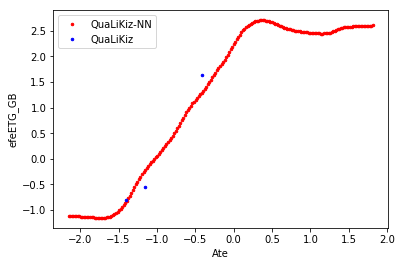

In [68]:
efeETG_DF = newDF['efeETG_GB']
Ate_DF = newDF['Ate']
plt.plot(table_normalized_Mk2[:,1], predictions_Mk2, 'r.', ms = 5, label = 'QuaLiKiz-NN')
plt.plot(Ate_DF_np_array, efeETG_DF_np_array, 'b.', ms = 5, label = 'QuaLiKiz')
plt.xlabel('Ate')
plt.ylabel('efeETG_GB')
plt.legend()
plt.show()

In [69]:
newDF_original = joined_dataFrame_original[An_mask10 & Ati_mask7 & qx_mask5 & smag_mask4 & x_mask4 & Ti_Te_mask5]  # Variable Ate

efeETG_DF_original = newDF_original['efeETG_GB']
efeETG_DF_original_np_array = efeETG_DF_original.values
print(efeETG_DF_original_np_array)

Ate_DF_original = newDF_original['Ate']
Ate_DF_original_np_array = Ate_DF_original.values
print(Ate_DF_original_np_array)

[ 7.413384 13.28646  63.69965 ]
[4.25 5.   7.25]


In [114]:
predictions_Mk2_deNormalized = (predictions_Mk2 * joined_dataFrame_original['efeETG_GB'].std()) + joined_dataFrame_original['efeETG_GB'].mean()
print(predictions_Mk2_deNormalized.shape)

(200,)


In [115]:
print(type(predictions_Mk2_deNormalized))

<class 'numpy.ndarray'>


In [116]:
predictions_Mk2_deNormalized

array([ 4.5399284e-01,  4.3781090e-01,  4.1854668e-01,  3.9611244e-01,
        3.7038612e-01,  3.4128952e-01,  3.0873299e-01,  2.7267265e-01,
        2.3311234e-01,  1.9006157e-01,  1.4365005e-01,  9.4085693e-02,
        4.1685104e-02, -1.3059616e-02, -6.9454193e-02, -1.2657166e-01,
       -1.8312263e-01, -2.3743439e-01, -2.8733444e-01, -3.2999802e-01,
       -3.6189651e-01, -3.7858391e-01, -3.7463570e-01, -3.4357071e-01,
       -2.7791405e-01, -1.6945076e-01, -9.7446442e-03,  2.0908928e-01,
        4.9338531e-01,  8.4698868e-01,  1.2708111e+00,  1.7632370e+00,
        2.3215256e+00,  2.9439449e+00,  3.6317902e+00,  4.3905144e+00,
        5.2292442e+00,  6.1583385e+00,  7.1852055e+00,  8.3090839e+00,
        9.5170021e+00,  1.0783474e+01,  1.2075790e+01,  1.3362187e+01,
        1.4618770e+01,  1.5831518e+01,  1.6994066e+01,  1.8104256e+01,
        1.9161486e+01,  2.0165777e+01,  2.1117844e+01,  2.2019756e+01,
        2.2875484e+01,  2.3691280e+01,  2.4475744e+01,  2.5239511e+01,
      

In [117]:
joined_dataFrame_original['Ate'].std()

3.0256382898842284

In [118]:
joined_dataFrame_original['Ate'].mean()

8.509738135487103

In [119]:
predictions_Mk2

array([-1.11725521e+00, -1.11796188e+00, -1.11880314e+00, -1.11978281e+00,
       -1.12090623e+00, -1.12217689e+00, -1.12359858e+00, -1.12517333e+00,
       -1.12690091e+00, -1.12878084e+00, -1.13080764e+00, -1.13297200e+00,
       -1.13526034e+00, -1.13765097e+00, -1.14011371e+00, -1.14260793e+00,
       -1.14507747e+00, -1.14744925e+00, -1.14962828e+00, -1.15149140e+00,
       -1.15288436e+00, -1.15361309e+00, -1.15344071e+00, -1.15208411e+00,
       -1.14921689e+00, -1.14448047e+00, -1.13750625e+00, -1.12794995e+00,
       -1.11553502e+00, -1.10009348e+00, -1.08158553e+00, -1.06008172e+00,
       -1.03570175e+00, -1.00852132e+00, -9.78483737e-01, -9.45350885e-01,
       -9.08724368e-01, -8.68151665e-01, -8.23309302e-01, -7.74230599e-01,
       -7.21481919e-01, -6.66176200e-01, -6.09741926e-01, -5.53566158e-01,
       -4.98692364e-01, -4.45732743e-01, -3.94965321e-01, -3.46484363e-01,
       -3.00316066e-01, -2.56459624e-01, -2.14883730e-01, -1.75498068e-01,
       -1.38129145e-01, -

(array([40.,  7., 10., 10.,  8.,  9., 10.,  8.,  8., 90.]),
 array([-1.15361309, -0.76752782, -0.38144255,  0.00464272,  0.390728  ,
         0.77681327,  1.16289854,  1.54898381,  1.93506908,  2.32115436,
         2.70723963]),
 <a list of 10 Patch objects>)

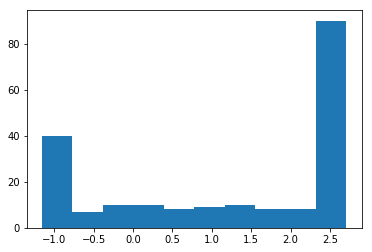

In [120]:
plt.hist(predictions_Mk2)

(200,)


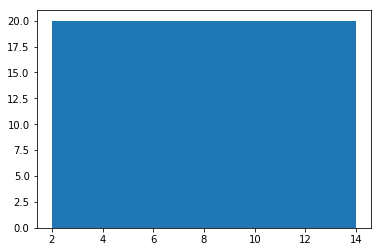

In [121]:
plt.hist(table[:,1])
print(table[:,1].shape)

([array([  0.,   0.,   0.,   0.,   0., 200.,   0.,   0.,   0.,   0.]),
  array([20., 20., 20., 20., 20., 20., 20., 20., 20., 20.]),
  array([  0.,   0.,   0.,   0.,   0.,   0., 200.,   0.,   0.,   0.]),
  array([  0.,   0.,   0.,   0., 200.,   0.,   0.,   0.,   0.,   0.]),
  array([  0.,   0.,   0.,   0.,   0., 200.,   0.,   0.,   0.,   0.]),
  array([  0.,   0.,   0.,   0.,   0., 200.,   0.,   0.,   0.,   0.]),
  array([  0.,   0.,   0.,   0.,   0., 200.,   0.,   0.,   0.,   0.])],
 array([-2.15152557, -1.75491504, -1.35830451, -0.96169398, -0.56508345,
        -0.16847293,  0.2281376 ,  0.62474813,  1.02135866,  1.41796919,
         1.81457971]),
 <a list of 7 Lists of Patches objects>)

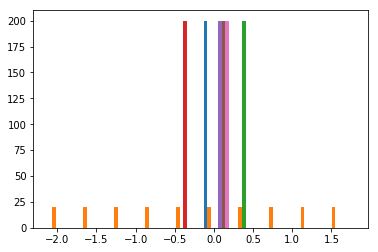

In [122]:
plt.hist(table_normalized_Mk2)

(array([1., 0., 1., 0., 0., 0., 0., 0., 0., 1.]),
 array([4.25, 4.55, 4.85, 5.15, 5.45, 5.75, 6.05, 6.35, 6.65, 6.95, 7.25]),
 <a list of 10 Patch objects>)

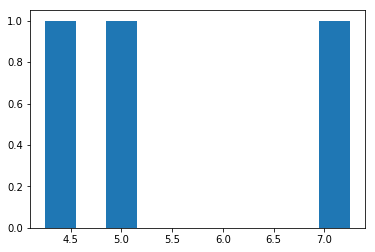

In [123]:
plt.hist(Ate_DF_original_np_array)

In [155]:
'''
#plt.plot(table[:,1], (predictions_Mk2 *20), 'g.', ms = 5, label = 'QuaLiKiz-NN')
# plt.plot(table[:,1], predictions_Mk2, 'r.', ms = 5, label = 'QuaLiKiz-NN')
plt.plot(table[:,1], predictions_Mk2_deNormalized, 'r.', ms = 5, label = 'QuaLiKiz-NN')
plt.plot(Ate_DF_original_np_array, efeETG_DF_original_np_array, 'b.', ms = 5, label = 'QuaLiKiz')
plt.xlabel('Ate')
plt.ylabel('efeETG_GB')
plt.legend()
plt.show()
'''

"\n#plt.plot(table[:,1], (predictions_Mk2 *20), 'g.', ms = 5, label = 'QuaLiKiz-NN')\n# plt.plot(table[:,1], predictions_Mk2, 'r.', ms = 5, label = 'QuaLiKiz-NN')\nplt.plot(table[:,1], predictions_Mk2_deNormalized, 'r.', ms = 5, label = 'QuaLiKiz-NN')\nplt.plot(Ate_DF_original_np_array, efeETG_DF_original_np_array, 'b.', ms = 5, label = 'QuaLiKiz')\nplt.xlabel('Ate')\nplt.ylabel('efeETG_GB')\nplt.legend()\nplt.show()\n"

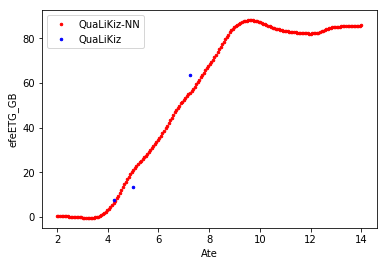

In [158]:
#plt.plot(table[:,1], (predictions_Mk2 *20), 'g.', ms = 5, label = 'QuaLiKiz-NN')
# plt.plot(table[:,1], predictions_Mk2, 'r.', ms = 5, label = 'QuaLiKiz-NN')
plt.plot(table[:,1], predictions_Mk2_deNormalized, 'r.', ms = 5, label = 'QuaLiKiz-NN')
plt.plot(Ate_DF_Mk2_np_array, efeETG_DF_Mk2_np_array, 'b.', ms = 5, label = 'QuaLiKiz')
plt.xlabel('Ate')
plt.ylabel('efeETG_GB')
plt.legend()
plt.savefig('./2018-07-17_TableTestingNotebook_Mk2/NN_Predictions.png', dpi = 100)
plt.show()

In [126]:
#Delta_predictions_Mk2 = numpy.linspace(0,0,200)
Delta_predictions_Mk2 = predictions_Mk2_deNormalized / predictions_Mk2

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1., 198.]),
 array([-13519.41503906, -12081.71001587, -10644.00499268,  -9206.29996948,
         -7768.59494629,  -6330.8899231 ,  -4893.1848999 ,  -3455.47987671,
         -2017.77485352,   -580.06983032,    857.63519287]),
 <a list of 10 Patch objects>)

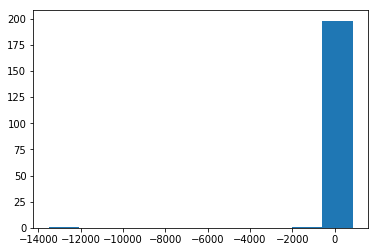

In [127]:
plt.hist(Delta_predictions_Mk2)

In [128]:
#Delta_Input_tables = numpy.linspace(0,0,200)
Delta_Input_tables = table[:,1] / table_normalized_Mk2[:,1]

(array([199.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([-444.93556639,  511.37628165, 1467.68812969, 2423.99997772,
        3380.31182576, 4336.6236738 , 5292.93552184, 6249.24736988,
        7205.55921792, 8161.87106595, 9118.18291399]),
 <a list of 10 Patch objects>)

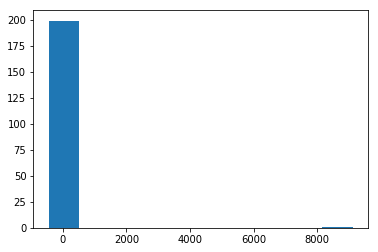

In [129]:
plt.hist(Delta_Input_tables)

(array([40.,  7., 10., 10.,  8.,  9., 10.,  8.,  8., 90.]),
 array([-1.15361309, -0.76752782, -0.38144255,  0.00464272,  0.390728  ,
         0.77681327,  1.16289854,  1.54898381,  1.93506908,  2.32115436,
         2.70723963]),
 <a list of 10 Patch objects>)

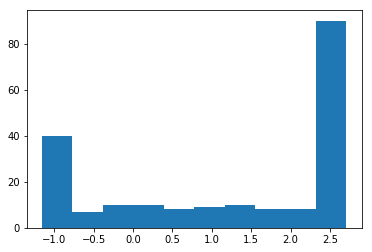

In [130]:
plt.hist(predictions_Mk2)

(array([40.,  7., 10., 10.,  8.,  9., 10.,  8.,  8., 90.]),
 array([-0.37858391,  8.46257343, 17.30373077, 26.14488811, 34.98604546,
        43.8272028 , 52.66836014, 61.50951748, 70.35067482, 79.19183216,
        88.0329895 ]),
 <a list of 10 Patch objects>)

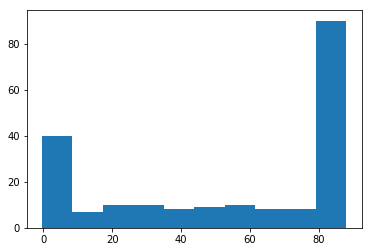

In [131]:
plt.hist(predictions_Mk2_deNormalized)

In [132]:
print(table[:,1])

[ 2.          2.06030151  2.12060302  2.18090452  2.24120603  2.30150754
  2.36180905  2.42211055  2.48241206  2.54271357  2.60301508  2.66331658
  2.72361809  2.7839196   2.84422111  2.90452261  2.96482412  3.02512563
  3.08542714  3.14572864  3.20603015  3.26633166  3.32663317  3.38693467
  3.44723618  3.50753769  3.5678392   3.6281407   3.68844221  3.74874372
  3.80904523  3.86934673  3.92964824  3.98994975  4.05025126  4.11055276
  4.17085427  4.23115578  4.29145729  4.35175879  4.4120603   4.47236181
  4.53266332  4.59296482  4.65326633  4.71356784  4.77386935  4.83417085
  4.89447236  4.95477387  5.01507538  5.07537688  5.13567839  5.1959799
  5.25628141  5.31658291  5.37688442  5.43718593  5.49748744  5.55778894
  5.61809045  5.67839196  5.73869347  5.79899497  5.85929648  5.91959799
  5.9798995   6.04020101  6.10050251  6.16080402  6.22110553  6.28140704
  6.34170854  6.40201005  6.46231156  6.52261307  6.58291457  6.64321608
  6.70351759  6.7638191   6.8241206   6.88442211  6.

In [133]:
print(Ate_DF_np_array.shape)

(3,)


In [134]:
print(efeETG_DF_np_array.shape)

(3,)


In [135]:
print(newDF_original.shape)

(3, 8)


In [136]:
print(newDF_original)

          efeETG_GB   Ati   Ate   An   qx  smag     x  Ti_Te
30963559   7.413384  5.75  4.25  3.0  3.0   0.7  0.45   1.33
31366759  13.286460  5.75  5.00  3.0  3.0   0.7  0.45   1.33
32576359  63.699650  5.75  7.25  3.0  3.0   0.7  0.45   1.33


In [137]:
table[:,1]

array([ 2.        ,  2.06030151,  2.12060302,  2.18090452,  2.24120603,
        2.30150754,  2.36180905,  2.42211055,  2.48241206,  2.54271357,
        2.60301508,  2.66331658,  2.72361809,  2.7839196 ,  2.84422111,
        2.90452261,  2.96482412,  3.02512563,  3.08542714,  3.14572864,
        3.20603015,  3.26633166,  3.32663317,  3.38693467,  3.44723618,
        3.50753769,  3.5678392 ,  3.6281407 ,  3.68844221,  3.74874372,
        3.80904523,  3.86934673,  3.92964824,  3.98994975,  4.05025126,
        4.11055276,  4.17085427,  4.23115578,  4.29145729,  4.35175879,
        4.4120603 ,  4.47236181,  4.53266332,  4.59296482,  4.65326633,
        4.71356784,  4.77386935,  4.83417085,  4.89447236,  4.95477387,
        5.01507538,  5.07537688,  5.13567839,  5.1959799 ,  5.25628141,
        5.31658291,  5.37688442,  5.43718593,  5.49748744,  5.55778894,
        5.61809045,  5.67839196,  5.73869347,  5.79899497,  5.85929648,
        5.91959799,  5.9798995 ,  6.04020101,  6.10050251,  6.16

In [138]:
table_normalized_Mk2[:,1]

array([-2.15152557e+00, -2.13159539e+00, -2.11166521e+00, -2.09173503e+00,
       -2.07180486e+00, -2.05187468e+00, -2.03194450e+00, -2.01201433e+00,
       -1.99208415e+00, -1.97215397e+00, -1.95222379e+00, -1.93229362e+00,
       -1.91236344e+00, -1.89243326e+00, -1.87250308e+00, -1.85257291e+00,
       -1.83264273e+00, -1.81271255e+00, -1.79278238e+00, -1.77285220e+00,
       -1.75292202e+00, -1.73299184e+00, -1.71306167e+00, -1.69313149e+00,
       -1.67320131e+00, -1.65327113e+00, -1.63334096e+00, -1.61341078e+00,
       -1.59348060e+00, -1.57355042e+00, -1.55362025e+00, -1.53369007e+00,
       -1.51375989e+00, -1.49382972e+00, -1.47389954e+00, -1.45396936e+00,
       -1.43403918e+00, -1.41410901e+00, -1.39417883e+00, -1.37424865e+00,
       -1.35431847e+00, -1.33438830e+00, -1.31445812e+00, -1.29452794e+00,
       -1.27459777e+00, -1.25466759e+00, -1.23473741e+00, -1.21480723e+00,
       -1.19487706e+00, -1.17494688e+00, -1.15501670e+00, -1.13508652e+00,
       -1.11515635e+00, -

In [139]:
print(table_normalized_Mk2[:,1].shape)

(200,)


In [140]:
table_normalized_Mk2[:,1].flatten()

array([-2.15152557e+00, -2.13159539e+00, -2.11166521e+00, -2.09173503e+00,
       -2.07180486e+00, -2.05187468e+00, -2.03194450e+00, -2.01201433e+00,
       -1.99208415e+00, -1.97215397e+00, -1.95222379e+00, -1.93229362e+00,
       -1.91236344e+00, -1.89243326e+00, -1.87250308e+00, -1.85257291e+00,
       -1.83264273e+00, -1.81271255e+00, -1.79278238e+00, -1.77285220e+00,
       -1.75292202e+00, -1.73299184e+00, -1.71306167e+00, -1.69313149e+00,
       -1.67320131e+00, -1.65327113e+00, -1.63334096e+00, -1.61341078e+00,
       -1.59348060e+00, -1.57355042e+00, -1.55362025e+00, -1.53369007e+00,
       -1.51375989e+00, -1.49382972e+00, -1.47389954e+00, -1.45396936e+00,
       -1.43403918e+00, -1.41410901e+00, -1.39417883e+00, -1.37424865e+00,
       -1.35431847e+00, -1.33438830e+00, -1.31445812e+00, -1.29452794e+00,
       -1.27459777e+00, -1.25466759e+00, -1.23473741e+00, -1.21480723e+00,
       -1.19487706e+00, -1.17494688e+00, -1.15501670e+00, -1.13508652e+00,
       -1.11515635e+00, -

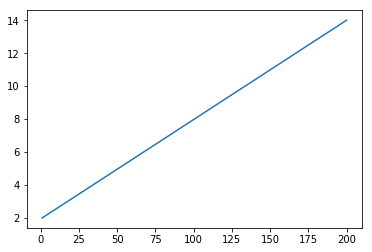

In [141]:
plt.plot(numpy.linspace(1,200,200), table[:,1])

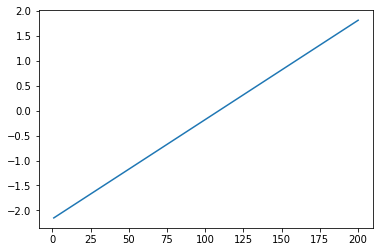

In [142]:
plt.plot(numpy.linspace(1,200,200), table_normalized_Mk2[:,1])

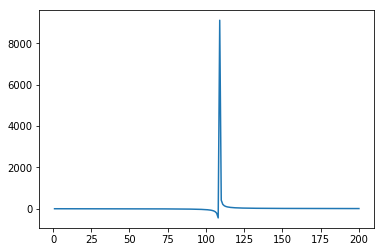

In [143]:
plt.plot(numpy.linspace(1,200,200), Delta_Input_tables)

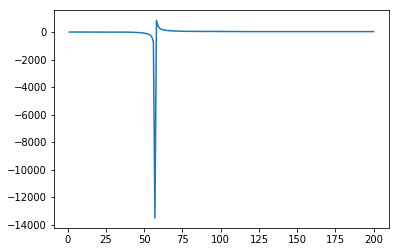

In [144]:
plt.plot(numpy.linspace(1,200,200), Delta_predictions_Mk2)

(50, 60)

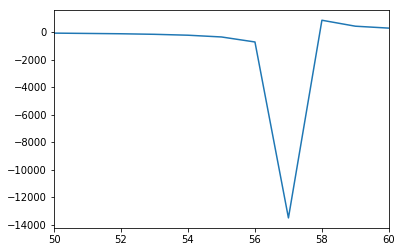

In [145]:
plt.plot(numpy.linspace(1,200,200), Delta_predictions_Mk2)
plt.xlim(50, 60)

In [146]:
print(predictions_Mk2[50])
print(predictions_Mk2[51])
print(predictions_Mk2[52])
print(predictions_Mk2[53])
print(predictions_Mk2[54])
print(predictions_Mk2[55])
print(predictions_Mk2[56])
print(predictions_Mk2[57])
print(predictions_Mk2[58])
print(predictions_Mk2[59])
print(predictions_Mk2[60])

-0.21488373
-0.17549807
-0.13812914
-0.102504134
-0.06824726
-0.034894273
-0.0019227564
0.031193793
0.06491041
0.09953222
0.13517094


In [147]:
predictions_Mk3_deNormalized = joined_dataFrame_original['Ate'].mean() + (predictions_Mk2 * joined_dataFrame_original['Ate'].std())
print(predictions_Mk3_deNormalized.shape)

(200,)


In [148]:
Delta_predictions_Mk3 = predictions_Mk3_deNormalized / predictions_Mk2

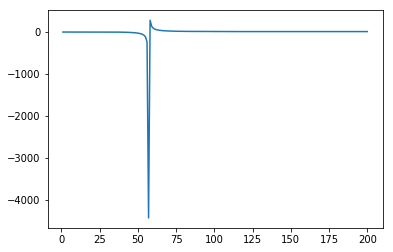

In [149]:
plt.plot(numpy.linspace(1,200,200), Delta_predictions_Mk3)

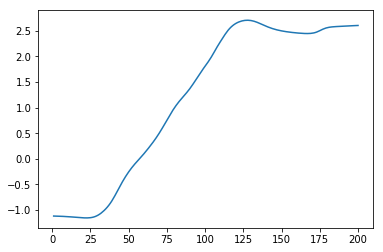

In [150]:
plt.plot(numpy.linspace(1,200,200), predictions_Mk2)

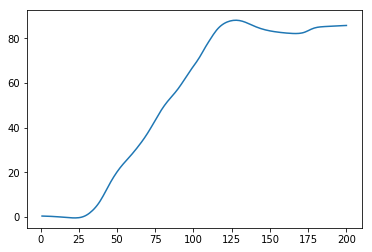

In [151]:
plt.plot(numpy.linspace(1,200,200), predictions_Mk2_deNormalized)

In [152]:
print(predictions_Mk2.shape)

(200,)


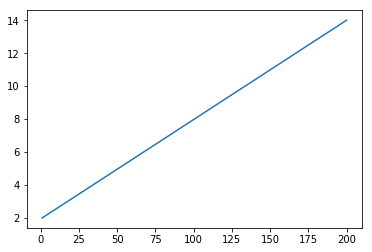

In [153]:
plt.plot(numpy.linspace(1,200,200), table[:,1])

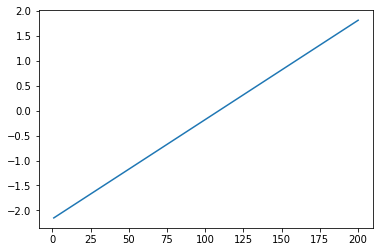

In [154]:
plt.plot(numpy.linspace(1,200,200), table_normalized_Mk2[:,1])